<a href="https://www.kaggle.com/code/iqmansingh/titanic-xgb-hyperparameter-tuning?scriptVersionId=135366569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Hyper Parameter Tuning on XGBClassifer**
1. RandomizedSearchCV
2. GridSearchCV
3. Hyperopt
4. TPOT (Genetic) Classifier
5. Optuna Optimizer


# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark")
plt.style.use('dark_background')
print("Setup Complete")

Setup Complete


# Importing Dataset

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv",index_col="PassengerId")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv",index_col="PassengerId")
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Cleaning

In [3]:
def extractCabin(cabin):
    if str(cabin) != "nan":
        cabin  = list(str(cabin).split())
        cabin.sort(reverse=True)
        cabin = str(cabin[0])[0]
    else:
        cabin = "U" # for unkown
    return cabin

train_data["Cabin"] = train_data["Cabin"].apply(extractCabin)
test_data["Cabin"] = test_data["Cabin"].apply(extractCabin)
train_data["Cabin"].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [4]:
from sklearn.preprocessing import LabelEncoder

train_data.drop(["Name","Ticket"],inplace=True,axis=1)
test_data.drop(["Name","Ticket"],inplace=True,axis=1)

encoder = LabelEncoder()
train_data["Sex"] = encoder.fit_transform(train_data["Sex"])
test_data["Sex"] = encoder.transform(test_data["Sex"])

train_data["Embarked"] = encoder.fit_transform(train_data["Embarked"])
test_data["Embarked"] = encoder.transform(test_data["Embarked"])

train_data["Cabin"] = encoder.fit_transform(train_data["Cabin"])
test_data["Cabin"] = encoder.transform(test_data["Cabin"])

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,8,2
2,1,1,0,38.0,1,0,71.2833,2,0
3,1,3,0,26.0,0,0,7.9250,8,2
4,1,1,0,35.0,1,0,53.1000,2,2
5,0,3,1,35.0,0,0,8.0500,8,2


In [5]:
ageMean = train_data["Age"].mean()
train_data["Age"] = train_data["Age"].fillna(value=ageMean)
test_data["Age"] = test_data["Age"].fillna(value=ageMean)
test_data["Fare"] = test_data["Fare"].fillna(method="ffill")

# EDA

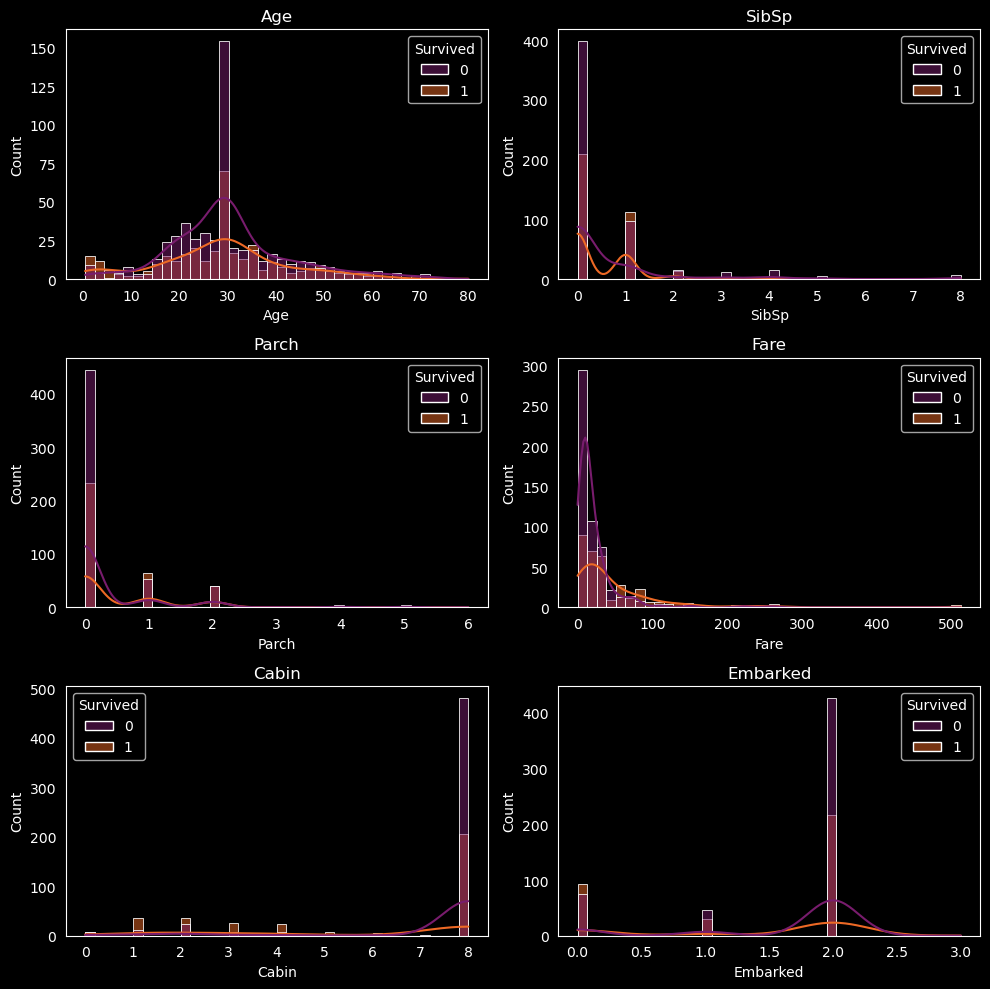

In [6]:
plotCols = [i for i in train_data.columns if len(train_data[i].unique())>3]
fig, axes = plt.subplots(3,2,figsize=(10, 10))
for i in range(len(plotCols)):
    plt.subplot(3,2,i+1)
    sns.histplot(train_data,x =plotCols[i],hue="Survived",bins=40,kde=True,palette="inferno")
    plt.gca().set_title(plotCols[i])
    
fig.tight_layout()
plt.show()

# Training Model

### **XGB Parameters Defaults**

---
-  booster = {*gbtree*, gblinear, dart}
-  verbosity = {0(Silent), 1(Warnings) ,2(Info) ,3(Debug)} 
-  max_depth = 3
-  learning_rate = 0.1
-  n_estimators = 100
-  gamma = 0
-  min_child_weight = 1
-  max_delta_step = 0
-  subsample = 1
-  sampling_method = {*uniform*, gradient_based (only supported in tree_method=gpu_hist)}
-  colsample_bytree = 1
-  colsample_bylevel = 1
-  colsample_bynode = 1
-  reg_alpha = 0 (L1 regularization) 
-  reg_lambda = 1 (L2 regularization) 
-  max_leaves = 0 (means no limit)
-  max_bin = 256
-  predictor = {*auto*, cpu_predictor, gpu_predictor (for tree_method=gpu_hist)}
-  tree_method = {*auto*, approx, hist, gpu_hist}
-  grow_policy = {*depthwise*, lossguide} 
-  eval_metric = {rmse, rmsle,mae, mape, mphe, logloss, error, error@t, merror, mlogloss, auc, aucpr, ndcg,poisson-nloglik, gamma-nloglik, cox-nloglik}
-  n_jobs=1
-  nthread=None
-  scale_pos_weight=1
-  base_score=0.5
-  random_state=0
-  silent = True
-  seed=None
-  missing=None

-  objective { 
 -  *reg:squarederror:* regression with squared loss.
 -  reg:squaredlogerror: regression with squared log loss. All input labels are required to be greater than -1.
 -  reg:logistic: logistic regression.
 -  reg:pseudohubererror: regression with Pseudo Huber loss, a twice differentiable alternative to absolute loss.
 -  reg:absoluteerror: Regression with L1 error.
 -  binary:logistic: logistic regression for binary classification, output probability
 -  binary:logitraw: logistic regression for binary classification, output score before logistic transformation
 -  binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
 -  count:poisson: Poisson regression for count data, output mean of Poisson distribution.max_delta_step = 0.7 by default
 -  survival:cox: Cox regression for right censored survival time data (negative values are considered right censored).
 -  survival:aft: Accelerated failure time model for censored survival time data.
 -  multi:softmax: set XGBoost to do multiclass classification using the softmax objective, you need to set no of classes
 -  multi:softprob: same as softmax, but output a vector of ndata * nclass, which can be reshaped to ndata * nclass matrix.
 -  rank:pairwise: Use LambdaMART to perform pairwise ranking where the pairwise loss is minimized
 -  rank:ndcg: Use LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized
 -  rank:map: Use LambdaMART to perform list-wise ranking where Mean Average Precision (MAP) is maximized
 -  reg:gamma: gamma regression with log-link. Output is a mean of gamma distribution.
 -  reg:tweedie: Tweedie regression with log-link.
 }

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from tpot import TPOTClassifier
import optuna

In [8]:
cols = [i for i in train_data.columns if i!="Survived"]
seed = np.random.seed(0)

X = train_data[cols]
y = train_data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

## 1. Baseline

In [9]:
xgbmodel_base = XGBClassifier(random_state=seed,tree_method = "gpu_hist",objective= "binary:logistic")
xgbmodel_base.fit(X_train,y_train)

print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_base.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_base.predict(X_test)))


 - Baseline Accuracy of XGB: 0.852017937219731

 - Baseline Conf Matrix of XGB:
 [[123  16]
 [ 17  67]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       139
           1       0.81      0.80      0.80        84

    accuracy                           0.85       223
   macro avg       0.84      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



## 2. Manual Tuning

In [10]:
xgbmodel_manual = XGBClassifier(n_estimators=500,learning_rate=0.04,random_state=seed,tree_method = "gpu_hist",objective= "binary:logistic")
xgbmodel_manual.fit(X_train,y_train)

print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_manual.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_manual.predict(X_test)))


 - Baseline Accuracy of XGB: 0.852017937219731

 - Baseline Conf Matrix of XGB:
 [[125  14]
 [ 19  65]]

 - Baseline Classification Report of XGB:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       139
           1       0.82      0.77      0.80        84

    accuracy                           0.85       223
   macro avg       0.85      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



## 2. RandomizedSearchCV 

In [11]:
params = {
    "n_estimators" : [int(x) for x in np.linspace(200,2000)],
    "max_depth" : [i for i in range(2,11)],
    "min_child_weight" : [i for i in range(1,6)],
    "max_delta_step" : [i for i in range(1,6)],
    "learning_rate" : [round(i,2) for i in np.linspace(0.1,2,20)],
    "gamma" : [round(i,2) for i in np.linspace(0,5,11)],
    "subsample" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bytree" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bylevel" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bynode" : [round(i,2) for i in np.linspace(0.1,1,10)]
}

In [12]:
xgbmodel = XGBClassifier(random_state=seed,tree_method = "gpu_hist",objective= "binary:logistic")

xgbmodel_rscv = RandomizedSearchCV(estimator=xgbmodel,param_distributions=params,n_iter=100,cv=3,verbose=3,scoring="accuracy")
xgbmodel_rscv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END colsample_bylevel=0.5, colsample_bynode=0.8, colsample_bytree=1.0, gamma=4.5, learning_rate=0.1, max_delta_step=3, max_depth=8, min_child_weight=2, n_estimators=971, subsample=0.3;, score=0.780 total time=   1.6s
[CV 2/3] END colsample_bylevel=0.5, colsample_bynode=0.8, colsample_bytree=1.0, gamma=4.5, learning_rate=0.1, max_delta_step=3, max_depth=8, min_child_weight=2, n_estimators=971, subsample=0.3;, score=0.803 total time=   1.5s
[CV 3/3] END colsample_bylevel=0.5, colsample_bynode=0.8, colsample_bytree=1.0, gamma=4.5, learning_rate=0.1, max_delta_step=3, max_depth=8, min_child_weight=2, n_estimators=971, subsample=0.3;, score=0.820 total time=   1.5s
[CV 1/3] END colsample_bylevel=0.4, colsample_bynode=0.8, colsample_bytree=1.0, gamma=4.5, learning_rate=1.3, max_delta_step=5, max_depth=7, min_child_weight=1, n_estimators=236, subsample=0.8;, score=0.789 total time=   0.4s
[CV 2/3] END colsample_bylevel=0.

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                                          1.3, 1.4, 1.5, 1.6,
                                                          1.7, 1.8, 1.9, 2.0],
                                        'max_delta_step': [1, 2, 3, 4, 5],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [200, 236, 273, 310,
                                                         346, 383, 420, 457,
                                                         493, 530, 567, 604,
                                                         640, 677, 714, 751,
                                                         787, 824, 861, 897,
                                                         934, 971, 1008, 1044,
                                                         1081, 1118, 1155, 1191,
                                                         1228, 1265, ...],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy', verbose=3)

In [13]:
best_params_rscv = xgbmodel_rscv.best_params_
best_xgb_rscv = xgbmodel_rscv.best_estimator_

print("\n","-"*100,"\n")
print("Best Params :",xgbmodel_rscv.best_params_)

print("\n","-"*100,"\n")
print("Best Evaluator :",xgbmodel_rscv.best_estimator_)

print("\n","-"*100,"\n")
print("\n - RSCV Accuracy of XGB:",accuracy_score(y_test, best_xgb_rscv.predict(X_test)))
print("\n - RSCV Conf Matrix of XGB:\n",confusion_matrix(y_test, best_xgb_rscv.predict(X_test)))
print("\n - RSCV Classification Report of XGB:\n",classification_report(y_test, best_xgb_rscv.predict(X_test)))


 ---------------------------------------------------------------------------------------------------- 

Best Params : {'subsample': 0.8, 'n_estimators': 640, 'min_child_weight': 4, 'max_depth': 6, 'max_delta_step': 4, 'learning_rate': 0.1, 'gamma': 2.5, 'colsample_bytree': 0.9, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.9}

 ---------------------------------------------------------------------------------------------------- 

Best Evaluator : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=0.5, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2.5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=4,
              max_depth=6, max_leaves=None, min_ch

## 3. GridSearchCV

In [39]:
params = {'subsample': [0.7], 
          'n_estimators': [383],
          'min_child_weight': [5],
          'max_depth': [4],
          'max_delta_step': [5],
          'learning_rate': [0.1],
          'gamma': [0.0],
          'colsample_bytree': 0.6,
          'colsample_bynode': 0.9,
          'colsample_bylevel': 0.3
         }

In [ ]:
xgbmodel = XGBClassifier(random_state=seed,tree_method = "gpu_hist")

xgbmodel_gscv = GridSearchCV(estimator=xgbmodel,param_grid=params,cv=3,verbose=3,scoring="accuracy")
xgbmodel_gscv.fit(X_train,y_train)

In [ ]:
best_params_gscv = xgbmodel_gscv.best_params_
best_xgb_gscv = xgbmodel_gscv.best_estimator_

print("\n","-"*100,"\n")
print("Best Params :",xgbmodel_gscv.best_params_)

print("\n","-"*100,"\n")
print("Best Evaluator :",xgbmodel_gscv.best_estimator_)

print("\n","-"*100,"\n")
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, best_xgb_gscv.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, best_xgb_gscv.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, best_xgb_gscv.predict(X_test)))

# 4. HyperOpt (Bayesian Automated-HyperParamter Tunning)

- Objective Function = defines the loss function to minimize.
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.


In [ ]:
space = {
    'n_estimators' : hp.choice('n_estimators',[int(x) for x in np.linspace(800,2000)]),
    'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    "learning_rate" : hp.uniform('learning_rate',0.05 , 2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 2),
    "colsample_bytree" : hp.uniform('colsample_bytree',0.5,1),
    "colsample_bylevel" : hp.uniform('colsample_bylevel',0.5,1),
    "colsample_bynode" : hp.uniform('colsample_bynode',0.5,1),
    'eval_metric': 'accuracy',
}



def objective(space):
    model = XGBClassifier(random_state=seed,tree_method = "gpu_hist",n_estimators = space["n_estimators"],max_depth = space["max_depth"],
              min_child_weight = space["min_child_weight"],learning_rate = space["learning_rate"],
              gamma = space["gamma"],subsample = space["subsample"],colsample_bytree = space["colsample_bytree"],colsample_bylevel = space["colsample_bylevel"],
              colsample_bynode = space["colsample_bynode"])

    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5,scoring='accuracy').mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }


In [ ]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 50,
            trials= trials)
best

In [ ]:
# 100%|██████████| 50/50 [07:15<00:00,  8.72s/trial, best loss: -0.969779209585727] 

hypopt_params = {'colsample_bylevel': 0.1,
 'colsample_bynode': 0.1,
 'colsample_bytree': 0.1,
 'gamma': 0.8622315538845127,
 'learning_rate': 0.13454749501702748,
 'max_depth': 2,
 'min_child_weight': 3.0,
 'n_estimators': 36,
 'subsample': 0.9104854458851901
                }

In [ ]:
print("\n","-"*100,"\n")
print("Best Params :",hypopt_params)

xgbmodel_hyperopt = XGBClassifier(random_state=seed,tree_method = "gpu_hist",**hypopt_params)
xgbmodel_hyperopt.fit(X,y)

print("\n","-"*100,"\n")
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, xgbmodel_hyperopt.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, xgbmodel_hyperopt.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, xgbmodel_hyperopt.predict(X_test)))

# 5. Genetic Algoritms (TPOT Classifier)

In [ ]:
params = {
    "n_estimators" : [int(x) for x in np.linspace(200,2000)],
    "max_depth" : [i for i in range(2,11)],
    "min_child_weight" : [i for i in range(1,6)],
    "max_delta_step" : [i for i in range(1,6)],
    "learning_rate" : [round(i,2) for i in np.linspace(0.1,2,20)],
    "gamma" : [round(i,2) for i in np.linspace(0,5,11)],
    "subsample" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bytree" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bylevel" : [round(i,2) for i in np.linspace(0.1,1,10)],
    "colsample_bynode" : [round(i,2) for i in np.linspace(0.1,1,10)]
}

In [ ]:
tpot_classifier = TPOTClassifier(generations= 5, population_size= 12, offspring_size= 6,
                                 verbosity= 2, early_stop= 10,
                                 config_dict={'xgboost.XGBClassifier': params}, 
                                 cv = 3, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train)

In [ ]:
print("\n","-"*100,"\n")
print("Score:", tpot_classifier.score(X_test,y_test))

print("\n","-"*100,"\n")
print("\n - Baseline Accuracy of XGB:",accuracy_score(y_test, tpot_classifier.predict(X_test)))
print("\n - Baseline Conf Matrix of XGB:\n",confusion_matrix(y_test, tpot_classifier.predict(X_test)))
print("\n - Baseline Classification Report of XGB:\n",classification_report(y_test, tpot_classifier.predict(X_test)))

# 6. Optuna Optimization

In [29]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

In [31]:
# dtrain = xgb.DMatrix(X_train, label=y_train)

#trial.suggest_categorical
#trial.suggest_float
#trial.suggest_int

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
    'n_estimators' : trial.suggest_int('n_estimators',2000,3000),
    'max_depth':  trial.suggest_int('max_depth',3,8),
    'min_child_weight': trial.suggest_float('min_child_weight', 2,4),
    "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.2),
    'subsample': trial.suggest_float('subsample', 0.2, 1),
    'gamma': trial.suggest_float("gamma", 1e-4, 1.0),
    "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
    "colsample_bylevel" : trial.suggest_float('colsample_bylevel',0.2,1),
    "colsample_bynode" : trial.suggest_float('colsample_bynode',0.2,1),
    }
    
    xgbmodel_optuna = XGBClassifier(**params,random_state=seed,tree_method = "gpu_hist")
    xgbmodel_optuna.fit(X,y)
    cv = cross_val_score(xgbmodel_optuna, X, y, cv = 4,scoring='accuracy').mean()
    return cv

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,timeout=1200)

[I 2023-06-30 17:07:33,577] A new study created in memory with name: no-name-095ee425-2c9b-4f13-9c5f-cf297b77c339
[I 2023-06-30 17:07:59,167] Trial 0 finished with value: 0.8260564376035229 and parameters: {'n_estimators': 2666, 'max_depth': 3, 'min_child_weight': 2.256832371687678, 'learning_rate': 0.04208265304544672, 'subsample': 0.8641771790734845, 'gamma': 0.18222463876025133, 'colsample_bytree': 0.2706566113673713, 'colsample_bylevel': 0.4563407465828072, 'colsample_bynode': 0.8652513706417231}. Best is trial 0 with value: 0.8260564376035229.
[I 2023-06-30 17:08:24,814] Trial 1 finished with value: 0.821582232456672 and parameters: {'n_estimators': 2722, 'max_depth': 6, 'min_child_weight': 2.425085046569177, 'learning_rate': 0.03557037274608168, 'subsample': 0.2926840281324564, 'gamma': 0.8178930838150804, 'colsample_bytree': 0.7444980154478569, 'colsample_bylevel': 0.6597343467788703, 'colsample_bynode': 0.24655730645966525}. Best is trial 0 with value: 0.8260564376035229.
[I 20

In [32]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [34]:
params_optuna = {'n_estimators': 2841, 'max_depth': 8, 'min_child_weight': 2.5383308853325546, 'learning_rate': 0.08852026860343602, 'subsample': 0.33258955834800524, 'gamma': 0.6930353117664744, 'colsample_bytree': 0.8564587172817348, 'colsample_bylevel': 0.8751775988569607, 'colsample_bynode': 0.42263701332966475}

xgbmodel_optuna = XGBClassifier(**params_optuna,random_state=seed,tree_method = "gpu_hist")
xgbmodel_optuna.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8751775988569607,
              colsample_bynode=0.42263701332966475,
              colsample_bytree=0.8564587172817348, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6930353117664744, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08852026860343602, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2.5383308853325546, missing=nan,
              monotone_constraints=None, n_estimators=2841, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

# Predictions

In [35]:
preds = xgbmodel_optuna.predict(test_data)

In [37]:
submission = test_data.copy()
submission["Survived"] = preds
colsToDrop = [i for i in submission.columns if i!="Survived"]
submission.drop(colsToDrop,axis=1,inplace=True)

In [38]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [39]:
submission.to_csv("submission_optuna.csv",header=True,index=True)